In [ ]:
#hide
#skip
! [ -e /content ] && pip install -Uqq espiownage fastai wwf # upgrade fastai on colab

# Prediction of Segmentation Regression - In Bulk (new Images)

*Acknowledgement: I took [Zach Mueller's Image Segmentation tutoral notebook](https://walkwithfastai.com/Segmentation) (based on the main FastAI lesson notebook) and modified it to do regression (as per Zach's suggestions) and to work with my own data.* 

In [ ]:
#all_slow

In [ ]:
!pip install -Uqq espiownage

# Libraries

In [ ]:
from fastai.vision.all import *
from espiownage.core import *

let's just get clear from the start which model we want:

In [ ]:
model_to_load = 'seg_reg_full_real_2' # .pth'

imgdir = '/home/sstudent/datasets/zooniverse_steelpan/'

Below you will find the exact imports for everything we use today

In [ ]:
from fastcore.xtras import Path

from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_flat_cos

from fastai.data.block import DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize

from fastai.layers import Mish   # MishJIT gives me trouble :-( 
from fastai.losses import BaseLoss, MSELossFlat, CrossEntropyLossFlat, BCEWithLogitsLossFlat
from fastai.optimizer import ranger

from fastai.torch_core import tensor

from fastai.vision.augment import aug_transforms
from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
from fastai.vision.learner import unet_learner

from PIL import Image
import numpy as np
import random

from torch import nn
from torchvision.models.resnet import resnet34

import torch
import torch.nn.functional as F

import glob
from pathlib import Path

In [ ]:
path = Path('/home/sstudent/datasets/espiownage-cleaner/')  # real data is local and private 
bin_size = 0.7  
maskdir = path / ('masks_'+str(bin_size))
path_im = path/'images'
path_lbl = path/maskdir
meta_names = sorted(glob.glob(str(path/'annotations')+'/*.csv'))
fnames = [meta_to_img_path(x, img_bank=path_im) for x in meta_names]
random.shuffle(fnames)
lbl_names = get_image_files(path_lbl)
get_msk = lambda o: path/maskdir/f'{o.stem}_P{o.suffix}'
colors = list(range(int(11/bin_size) + 1))
codes = [str(n) for n in range(len(colors))]; codes
sz = (384,512)
db = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
    get_items=get_image_files,
    splitter=RandomSplitter(),
    get_y=get_msk,
    batch_tfms=[*aug_transforms(size=sz, flip_vert=True), Normalize.from_stats(*imagenet_stats)])
    
dls = db.dataloaders(path/'images', fnames=fnames, bs=16)  # if OOM occurs lower bs to as low as 2
dls.vocab = codes

/home/sstudent/.local/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/home/sstudent/.local/lib/python3.8/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.

In [ ]:
opt = ranger 
hrfac = 1.2  # 'headroom factor'
codes = [str(n) for n in range(16)]; codes
y_range=(0,int(len(codes)*hrfac))  # balance between "clamping" to range of real data vs too much "compression" from sigmoid nonlineari
learn = unet_learner(dls, resnet34, n_out=1, y_range=y_range, loss_func=MSELossFlat(), self_attention=True, act_cls=Mish, opt_func=opt)
learn.load('seg_reg_full_real_2')

/home/sstudent/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
from PIL import ImageOps 

def save_tmask(tmask, fname='', norm=False, purple=False, blend_img=None): # save tensor mask
    tmask_new = tmask[0].squeeze().cpu().numpy() 
    use_min, use_max = 0, np.max(np.array(colors))    # use scale of max ring count
    if norm: use_min, use_max = tmask_new.min(), tmask_new.max()   # auto scale for just this image
    rescaled = (255.0 / use_max * (tmask_new - use_min)).astype(np.uint8)
    im = Image.fromarray(rescaled)
    if purple: im = ImageOps.colorize(im, black ="black", white =(255,0,255))
    if blend_img is not None: im = Image.blend(blend_img, im, 0.4)
    if fname != '': im.save(fname)
    return im

In [ ]:
pfnames = sorted(glob.glob(imgdir+'/*.png'))
print(pfnames[0],pfnames[1000])
print(len(pfnames))

pf = pfnames[0]
im = img = PILImage.create(pf)

#dlpred = dls.test_dl([pfile])
#preds, _ = learn.get_preds(dl=dlpred)
#preds = preds.squeeze(1)
#print(preds.shape)

/home/sstudent/datasets/zooniverse_steelpan/06240907_proc_00000.png /home/sstudent/datasets/zooniverse_steelpan/06240907_proc_01000.png
14000


In [ ]:
dlpred = dls.test_dl(pfnames)
preds, _ = learn.get_preds(dl=dlpred)
preds = preds.squeeze(1)

In [ ]:
outdir = 'bulk_segreg_purple'
!mkdir {outdir}

In [ ]:
for i, pfile in enumerate(pfnames):
    mfile = outdir+'/'+str(Path(pfile).stem)+'_RM.png'
    if i% 250 == 0: print(f"{i}: saving {mfile}") 
    im = save_tmask(preds[i], mfile, purple=True, blend_img=Image.open(pfile).convert('RGB'))

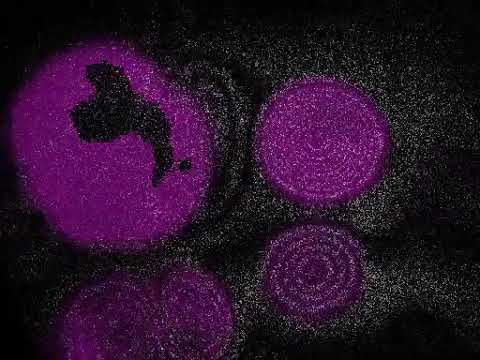

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('-PSbn8nRhro')

## Pick a point, any point 
We can use the segmentation-regression to graph ring estimates at a single pixel as a function of frame number.
Use the new version of the ellipse editor to select a pixel, then find out what frame number that image corresponds to (out of 14000 frames), and plot! 

In the image below we'll pick out the point (216,139), right on the center of one of the antinodes.  And we'll figure out what the frame number over the 140000 frames is using the filename only with '.png':

![pick_a_point_screenshot](https://i.imgur.com/yWx3VsM.png)


In [ ]:
x, y = 216, 139  # coordinates of pixel
filename = '06241902_proc_01502.png'
print(f"Frame number is {[os.path.basename(x) for x in pfnames].index(filename)}") 

Frame number is 13502


Text(0.5, 0, 'frame')

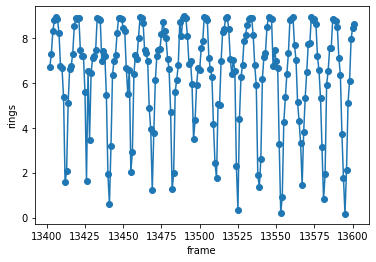

In [ ]:
start, end = 13502-100, 13502+100  # frames to start & end the plot
data = preds[start:end, y, x].cpu().numpy()*bin_size
plt.plot(range(start,end), data,'o-')
plt.ylabel('rings')
plt.xlabel('frame')

Then fit a line to that and get its period...?




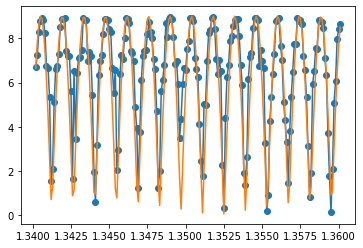

In [ ]:
t = np.arange(start,end)/10000
plt.plot(t, data,'o-')
plt.plot(t, np.abs(np.cos(2*np.pi*355*t+.7))*9,'-')

Output our points to use in a real plotting program:

In [ ]:
np.savetxt('rings_vs_t_13400-13600_sr.txt',data)

Save all our predictions as a giant 3D file:

In [ ]:
predu8 = preds.cpu().numpy().astype(np.uint8)

In [ ]:
predu8.shape

(14000, 384, 512)

In [ ]:
np.save('seg_reg_array_uint8',predu8, allow_pickle=False)